<a href="https://colab.research.google.com/github/manahil882/localrepo/blob/main/Copy_of_Classifier_Notebook_v1_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.datasets as datasets
import torchvision.transforms as transforms
from torch.autograd import Variable

import matplotlib.pyplot as plt
import shutil
import numpy as np
import math
import os

# classes = ('female', 'male')
classes = ('old', 'young')

In [ ]:
!ls -l gender_age_classification/age-data

ls: cannot access 'gender_age_classification/age-data': No such file or directory


In [ ]:
!git clone https://github.com/jiechen2358/FaceAging-by-cycleGAN.git

Cloning into 'FaceAging-by-cycleGAN'...
remote: Enumerating objects: 9050, done.
remote: Total 9050 (delta 0), reused 0 (delta 0), pack-reused 9050
Receiving objects: 100% (9050/9050), 2.09 GiB | 67.71 MiB/s, done.
Resolving deltas: 100% (365/365), done.
Updating files: 100% (6335/6335), done.


In [ ]:
!rm -rf FaceAging-by-cycleGAN

In [ ]:
!git clone https://github.com/jiechen2358/FaceAging-by-cycleGAN.git

Cloning into 'FaceAging-by-cycleGAN'...
remote: Enumerating objects: 9050, done.
remote: Total 9050 (delta 0), reused 0 (delta 0), pack-reused 9050
Receiving objects: 100% (9050/9050), 2.09 GiB | 32.69 MiB/s, done.
Resolving deltas: 100% (365/365), done.
Updating files: 100% (6335/6335), done.


In [ ]:
!git clone --depth=1 --branch=master https://github.com/jiechen2358/FaceAging-by-cycleGAN.git

Cloning into 'FaceAging-by-cycleGAN'...
remote: Enumerating objects: 6000, done.
remote: Counting objects: 100% (6000/6000), done.
remote: Compressing objects: 100% (5952/5952), done.
remote: Total 6000 (delta 47), reused 5970 (delta 43), pack-reused 0
Receiving objects: 100% (6000/6000), 1.56 GiB | 63.68 MiB/s, done.
Resolving deltas: 100% (47/47), done.
Updating files: 100% (6335/6335), done.


In [ ]:
%cd FaceAging-by-cycleGAN/gender_age_classification

/content/FaceAging-by-cycleGAN/gender_age_classification


In [ ]:
!ls

age-data     Classifier_Notebook_v1.0.ipynb  gender-data  predict.py
checkpoints  gender_age_classifier.py	     __init__.py  README.md


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super(Net,self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(3,96,kernel_size=7,stride=4),
            nn.BatchNorm2d(96),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        self.conv2 = nn.Sequential(
            nn.Conv2d(96,256,kernel_size=5,padding=2),
            nn.BatchNorm2d(256),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        self.conv3 = nn.Sequential(
            nn.Conv2d(256,384,kernel_size=3,padding=1),
            nn.BatchNorm2d(384),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=3,stride=2))
        self.fc1 = nn.Linear(384*6*6,512)
        self.fc2 = nn.Linear(512,512)
        self.fc3 = nn.Linear(512,2)

    def forward(self,x):
        x = self.conv1(x)
        x = self.conv2(x)
        x = self.conv3(x)
        x = x.view(x.size(0),-1)
        x = F.dropout(F.relu(self.fc1(x)))
        x = F.dropout(F.relu(self.fc2(x)))
        x = self.fc3(x)
        return x

In [ ]:
model = Net()
# print(model)
# print("Model's state dict:")
# for param_tensor in model.state_dict():
#     print(param_tensor, "\t", model.state_dict()[param_tensor].size())
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

# Print optimizer's state_dict
# print("Optimizer's state_dict:")
# for var_name in optimizer.state_dict():
#     print(var_name, "\t", optimizer.state_dict()[var_name])

In [ ]:
def check_acc(model,data_loader):
    num_correct,num_sample = 0, 0
    for images,labels in data_loader:
        images = Variable(images)
        outputs = model(images)
        _,pred = torch.max(outputs.data,1)
        num_sample += labels.size(0)
        num_correct += (pred == labels).sum()
    return float(num_correct)/num_sample

In [ ]:
def plot_performance(epoches, train_accs, val_accs, path = 'performance.png'):
    plt.figure()
    plt.plot(np.array(epoches), np.array(train_accs), label = 'training accuracy')
    plt.plot(np.array(epoches), np.array(val_accs), label = 'validation accuracy')
    plt.title('Accuracy on training & validation')
    plt.ylabel('Accuracy')
    plt.xlabel('Number of epoch')
    plt.legend()
    plt.savefig(path)

def plot_loss_vs_iterations(losses, path = 'loss.png'):
    plt.figure()
    plt.plot(np.array(losses))
    plt.title('Loss vs. iterations')
    plt.ylabel('Loss')
    plt.xlabel('Number of iterations')
    plt.savefig(path)

def save_checkpoint(state, is_best, file_name = 'checkpoint.tar'):
    torch.save(state,file_name)
    if is_best:
        shutil.copyfile(file_name,'model_best.tar')

def load_images(train_root, test_root, train_transform, test_transform):
    '''train_root and test_root are strs'''
    print('Loading images...')
    train_data = datasets.ImageFolder(root=train_root,transform=train_transform)
    test_data = datasets.ImageFolder(root=test_root,transform=test_transform)
    print('Train data length:', len(train_data))
    print('Validate data length:', len(test_data))
    return train_data, test_data

In [ ]:
def main():
    train_accs = []
    val_accs = []
    epoches = []
    losses = []
    learning_rate = 0.001
    best_val_acc = 0.0
    batch_size = 64
    num_epochs = 100

    train_transform = transforms.Compose(
        [transforms.Resize(256),
         transforms.RandomCrop(227),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor()])

    test_transform = transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(227),
        transforms.ToTensor()])

#    root = 'gender-data'
    root = 'age-data'
    #root = 'https://github.com/jiechen2358/FaceAging-by-cycleGAN/tree/master/gender_age_classification/age-data'
    train_data_path = os.path.join(root, 'train')
    test_data_path = os.path.join(root, 'test')
    train_data, test_data = load_images(train_data_path, test_data_path, train_transform, test_transform)

    train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size,shuffle=True,num_workers=4)
    test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size,shuffle=False,num_workers=4)

    model = Net()
    criterion = nn.CrossEntropyLoss()

    for epoch in range(num_epochs):
        # optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        print('Starting epoch %d / %d' % (epoch + 1, num_epochs))
        print('Learning Rate: {}'.format(learning_rate))

        for i,(images,labels) in enumerate(train_loader):
            images = Variable(images)
            labels = Variable(labels)
            pred_labels = model(images)
            loss = criterion(pred_labels,labels)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            losses.append(loss.data.item())
            print ('Epoch [%d/%d], Iter [%d/%d] Loss: %.4f'
                   %(epoch+1, num_epochs, i+1, math.ceil(len(train_data)/batch_size), loss.data.item()))

        if (epoch + 1) % 5 == 0:
            learning_rate = learning_rate * 0.9
            print('update learning rate:', learning_rate)

        if (epoch + 1) % 5 == 0 or epoch + 1 == num_epochs:
            train_acc = check_acc(model,train_loader)
            train_accs.append(train_acc)
            print('Train accuracy for epoch {}: {} '.format(epoch + 1,train_acc))

            val_acc = check_acc(model,test_loader)
            val_accs.append(val_acc)
            print('Validation accuracy for epoch {} : {} '.format(epoch + 1,val_acc))

            epoches.append(epoch+1)

            is_best = (val_acc > best_val_acc)
            best_val_acc = max(val_acc,best_val_acc)
            save_checkpoint(
                {'epoch':epoch+1,
                 'model_state_dict':model.state_dict(),
                 'best_val_acc':best_val_acc,
                 'optimizer':optimizer.state_dict()}, is_best, file_name = 'checkpoint'+ str(epoch+1) +'.tar')

    plot_performance(epoches, train_accs, val_accs)
    plot_loss_vs_iterations(losses)


Loading images...
Train data length: 1058
Validate data length: 83
Starting epoch 1 / 100
Learning Rate: 0.001


/usr/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


Epoch [1/100], Iter [1/17] Loss: 0.6874
Epoch [1/100], Iter [2/17] Loss: 1.6877
Epoch [1/100], Iter [3/17] Loss: 9.4321
Epoch [1/100], Iter [4/17] Loss: 3.5829
Epoch [1/100], Iter [5/17] Loss: 5.5756
Epoch [1/100], Iter [6/17] Loss: 3.7483
Epoch [1/100], Iter [7/17] Loss: 1.1864
Epoch [1/100], Iter [8/17] Loss: 2.0032
Epoch [1/100], Iter [9/17] Loss: 2.3276
Epoch [1/100], Iter [10/17] Loss: 1.7894
Epoch [1/100], Iter [11/17] Loss: 1.0054
Epoch [1/100], Iter [12/17] Loss: 1.2602
Epoch [1/100], Iter [13/17] Loss: 1.3438
Epoch [1/100], Iter [14/17] Loss: 1.4860
Epoch [1/100], Iter [15/17] Loss: 0.8556
Epoch [1/100], Iter [16/17] Loss: 0.9356
Epoch [1/100], Iter [17/17] Loss: 1.3266
Starting epoch 2 / 100
Learning Rate: 0.001
Epoch [2/100], Iter [1/17] Loss: 1.0344
Epoch [2/100], Iter [2/17] Loss: 1.6742
Epoch [2/100], Iter [3/17] Loss: 0.9800
Epoch [2/100], Iter [4/17] Loss: 1.1072
Epoch [2/100], Iter [5/17] Loss: 0.8220
Epoch [2/100], Iter [6/17] Loss: 0.8895
Epoch [2/100], Iter [7/17] L

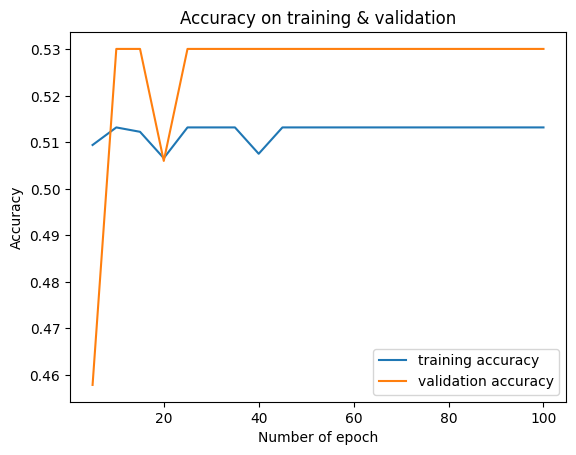

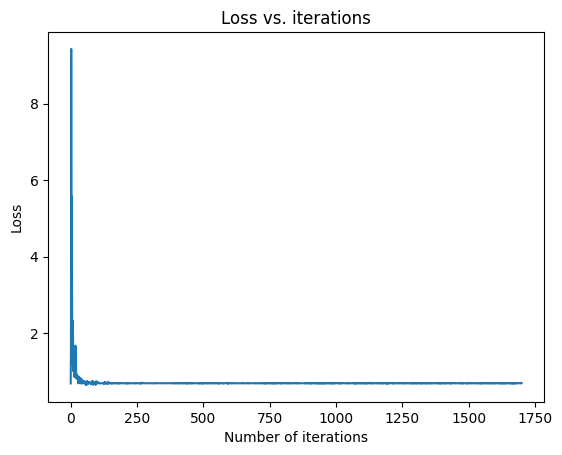

In [ ]:
main()

In [ ]:
train_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.RandomCrop(227),
     transforms.RandomHorizontalFlip(),
     transforms.ToTensor()])

test_transform = transforms.Compose(
    [transforms.Resize(256),
     transforms.CenterCrop(227),
     transforms.ToTensor()])

# root = 'gender-data'
root = 'age-data'
train_data_path = os.path.join(root, 'train')
test_data_path = os.path.join(root, 'test')
train_data, test_data = load_images(train_data_path, test_data_path, train_transform, test_transform)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=20,shuffle=True,num_workers=4)

Loading images...
Train data length: 1058
Validate data length: 83


In [ ]:
def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()

In [ ]:
model = Net()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

checkpoint = torch.load(os.path.join('','model_best.tar'))
model.load_state_dict(checkpoint['model_state_dict'])
epoch = checkpoint['epoch']

optimizer.load_state_dict(checkpoint['optimizer'])

model.eval()

Net(
  (conv1): Sequential(
    (0): Conv2d(3, 96, kernel_size=(7, 7), stride=(4, 4))
    (1): BatchNorm2d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv2): Sequential(
    (0): Conv2d(96, 256, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv3): Sequential(
    (0): Conv2d(256, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(384, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=13824, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=512, bias=True)
  (fc3):

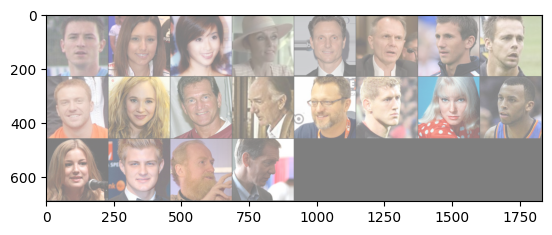

GroundTruth:  young young young   old   old   old young young young young   old   old   old young young young young young   old   old
##Predicted:  young young young young young young young young young young young young young young young young young young young young


In [ ]:
# GroundTruth
for images, labels in test_loader:
    # show images
    imshow(torchvision.utils.make_grid(images))
    # print labels
    print('GroundTruth: ', ' '.join('%5s' % classes[labels[j]] for j in range(len(labels))))

    # Predict
    outputs = model(images)
    _, predicted = torch.max(outputs, 1)
    print('##Predicted: ', ' '.join('%5s' % classes[predicted[j]] for j in range(len(labels))))
    break  # Only display one batch of data for demonstration purposes